# Initialization

In [1]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt
import pickle

### Custom functions
import modules as md

Running in Google Colab
Cloning into 'anesthesia_anomaly_detection'...
remote: Enumerating objects: 963, done.
remote: Total 963 (delta 0), reused 0 (delta 0), pack-reused 963
Receiving objects: 100% (963/963), 197.20 MiB | 27.37 MiB/s, done.
Resolving deltas: 100% (531/531), done.
Updating files: 100% (369/369), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.3 MB/s eta 0:00:00


# Data loading

In [2]:
###### Create Dataset
if create_dataset:
    bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bis.name = 'Bispektralindex'
    bis.tracks = ['BIS/BIS']
    bis.filter = [20, 10, 100]
    bis.generateDataset(normalization=md.NormNone)
    bis.save('00_bis.npz')

    info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    info.generateDataset(normalization=md.NormStandard)
    info.save('01_info.npz')

    bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bloodpressure.name = 'bloodpressure'
    bloodpressure.tracks = ['Solar8000/ART_DBP', 'Solar8000/ART_MBP', 'Solar8000/ART_SBP']
    bloodpressure.filter = [20, 20, 250]
    bloodpressure.generateDataset(normalization=md.NormStandard)
    bloodpressure.save('02_bloodpressure.npz')

    etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    etCO2.name = 'End Tidal CO2'
    etCO2.tracks = ['Primus/ETCO2']
    etCO2.filter = [5, 15, 50]
    etCO2.generateDataset(normalization=md.NormStandard)
    etCO2.save('02_etCO2.npz')

    spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    spO2.name = 'SpO2'
    spO2.tracks = ['Solar8000/PLETH_SPO2']
    spO2.filter = [3, 80, 100]
    spO2.generateDataset(normalization=md.NormStandard)
    spO2.save('02_spO2.npz')

    hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    hr.name = 'Heart Rate'
    hr.tracks = ['Solar8000/HR']
    hr.filter = [20, 40, 180]
    hr.generateDataset(normalization=md.NormStandard)
    hr.save('02_hr.npz')

    propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    propofolrate.name = 'Propofol Rate'
    propofolrate.tracks = ['Orchestra/PPF20_RATE']
    propofolrate.filterON = False
    propofolrate.generateDataset(normalization=md.NormNone)
    propofolrate.save('03_propofol_rate.npz')

    remifentanilrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    remifentanilrate.name = 'Remifentanil Rate'
    remifentanilrate.tracks = ['Orchestra/RFTN20_RATE']
    remifentanilrate.filterON = False
    remifentanilrate.generateDataset(normalization=md.NormNone)
    remifentanilrate.save('03_remifentanil_rate.npz')

### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

remifentanilrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
remifentanilrate.load('03_remifentanil_rate.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

# Seperate the Data in Male and Female patients

In [3]:
m_index_train = np.where(info.train_dataset[:,0] == 0.5)
f_index_train = np.where(info.train_dataset[:,0] == -0.5)

m_index_val = np.where(info.validation_dataset[:,0] == 0.5)
f_index_val = np.where(info.validation_dataset[:,0] == -0.5)

m_index_test = np.where(info.test_dataset[:,0] == 0.5)
f_index_test = np.where(info.test_dataset[:,0] == -0.5)

# Model creation

In [4]:
########################################## COMBINED MODEL ##########################################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU, Dropout, Concatenate, Masking, Conv1D, MaxPooling1D, BatchNormalization, RepeatVector, Lambda
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

### Blood Pressure Input
input_bp = Input(shape=(None, bloodpressure.train_dataset.shape[2]))
bp_layer = Masking(mask_value=0.0)(input_bp)

bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=128, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=16, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=16, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = Dense(units=16, activation='linear')(bp_layer)

### etCO2 Input
input_co2 = Input(shape=(None, etCO2.train_dataset.shape[2]))

co2_layer = LSTM(units=64, return_sequences=True)(input_co2)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=64, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=64, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=16, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=8, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = Dense(units=8, activation='linear')(co2_layer)

### spo2 Input
input_spo2 = Input(shape=(None, spO2.train_dataset.shape[2]))

spo2_layer = LSTM(units=64, return_sequences=True)(input_spo2)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=64, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=64, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=16, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=8, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = Dense(units=8, activation='linear')(spo2_layer)

# Prpofol layers
input_propofol = Input(shape=(None, propofolrate.train_dataset.shape[2]))
propofol_layer = BatchNormalization()(input_propofol)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=128, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=16, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=16, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = Dense(units=16, activation='linear')(propofol_layer)

### INFO layers
input_info = Input(shape=(info.train_dataset.shape[1],))
info_layer = RepeatVector(bloodpressure.train_dataset.shape[1])(input_info)
info_layer = Dense(units=16, activation='linear')(info_layer)
info_layer = Dense(units=16, activation='sigmoid')(info_layer)


## Concatenate the Propofol output with the info layer
comb_layer = Concatenate()([bp_layer, co2_layer, spo2_layer, propofol_layer, info_layer])
comb_layer = Dense(units=64, activation='linear')(comb_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=32, activation='relu')(comb_layer)
comb_layer = Dense(units=16, activation='relu')(comb_layer)
comb_layer = Dense(units=1, activation=ReLU(max_value=1.0))(comb_layer)
output = Lambda(lambda x: x * 100)(comb_layer)

# Define the model
model = Model(inputs=[input_bp, input_co2, input_spo2, input_propofol, input_info], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError','MeanAbsoluteError','RootMeanSquaredError']
              )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 masking (Masking)           (None, None, 3)              0         ['input_1[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, None, 1)              4         ['input_4[0][0]']             
 tchNormalization)                                                                            

# Model Training on male patients

In [5]:
# Rolling mean on BIS data
y = pd.DataFrame(bis.train_dataset[:,:,0].T).rolling(min_periods=1,window=3, center=True).mean().to_numpy().T[:,:,np.newaxis]

# Define training stop criteria
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopTrainingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') is not None:
            if logs.get('val_loss') < self.threshold:
                print(f"\nValidation loss is below {self.threshold}, stopping training.")
                self.model.stop_training = True

stop_training_callback = StopTrainingCallback(threshold = 35)


if in_google_colab():
    # Train the model
    history = model.fit([bloodpressure.train_dataset[m_index_train], etCO2.train_dataset[m_index_train], spO2.train_dataset[m_index_train], propofolrate.train_dataset[m_index_train], info.train_dataset[m_index_train]],
                        bis.train_dataset[m_index_train],
                        validation_data=([bloodpressure.validation_dataset[m_index_val], etCO2.validation_dataset[m_index_val], spO2.validation_dataset[m_index_val], propofolrate.validation_dataset[m_index_val], info.validation_dataset[m_index_val]], bis.validation_dataset[m_index_val]),
                        epochs=150,
                        callbacks=[stop_training_callback],
                        batch_size=4
                        )

    train_score = history.history

    # Save the model
    model.save('download/model.keras')

    # Save the training history
    with open('download/train_score.pkl', 'wb') as f:
        pickle.dump(train_score, f)

    # Save the prediction
    y_pred_male = model.predict([bloodpressure.test_dataset[m_index_test], etCO2.test_dataset[m_index_test], spO2.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test], info.test_dataset[m_index_test]], verbose=0)
    with open('download/prediction_male.pkl', 'wb') as f:
        pickle.dump(y_pred_male, f)

    y_pred_female = model.predict([bloodpressure.test_dataset[f_index_test], etCO2.test_dataset[f_index_test], spO2.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test], info.test_dataset[f_index_test]], verbose=0)
    with open('download/prediction_female.pkl', 'wb') as f:
        pickle.dump(y_pred_female, f)

else:
    # Load train score data
    with open('train_score.pkl', 'rb') as f:
        train_score = pickle.load(f)

    # Load test prediction data
    with open('prediction_male.pkl', 'rb') as f:
        y_pred_male = pickle.load(f)

    with open('prediction_female.pkl', 'rb') as f:
        y_pred_female = pickle.load(f)

Epoch 1/150
19/19 [==============================] - 145s 3s/step - loss: 927.7103 - mean_squared_error: 927.7102 - mean_absolute_error: 19.5884 - root_mean_squared_error: 30.4583 - val_loss: 914.6976 - val_mean_squared_error: 914.6976 - val_mean_absolute_error: 19.0638 - val_root_mean_squared_error: 30.2440
Epoch 2/150
19/19 [==============================] - 39s 2s/step - loss: 392.7150 - mean_squared_error: 392.7150 - mean_absolute_error: 10.3600 - root_mean_squared_error: 19.8170 - val_loss: 554.0493 - val_mean_squared_error: 554.0493 - val_mean_absolute_error: 20.1318 - val_root_mean_squared_error: 23.5382
Epoch 3/150
19/19 [==============================] - 39s 2s/step - loss: 134.3294 - mean_squared_error: 134.3294 - mean_absolute_error: 5.8590 - root_mean_squared_error: 11.5901 - val_loss: 586.9846 - val_mean_squared_error: 586.9846 - val_mean_absolute_error: 22.4058 - val_root_mean_squared_error: 24.2278
Epoch 4/150
19/19 [==============================] - 39s 2s/step - loss: 

# Training results

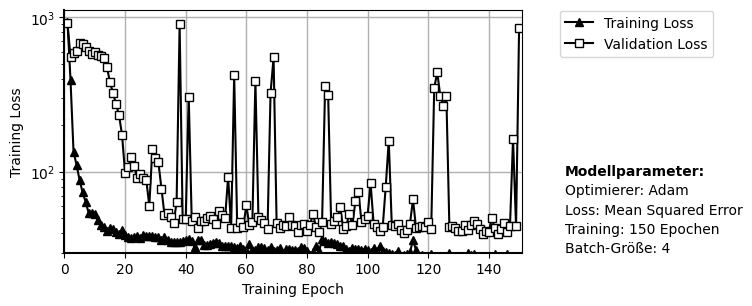

In [6]:
from utils.plotting import training_loss_plot

plot = training_loss_plot(train_score, filename='download/training_loss.pdf')
plot.show()

# Testing Male

In [7]:
### Predict on the test set
from utils.evaluation import phases_report, phases_report_std

print('Testmetriken:')

report = phases_report(y_pred_male, bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])
report

Testmetriken:


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,75.64,122.47,6.53,6.94,8.70,11.07
Induction,174.99,600.22,10.25,17.60,13.23,24.50
Maintenance,59.89,53.44,5.96,5.27,7.74,7.31
Recovery,149.73,335.83,8.85,12.74,12.24,18.33


In [8]:
phases_report_std(report, y_pred_male, bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])

All      	min: 	 9 	max: 	 15
Induction 	min: 	 17 	max: 	 6
Maintenance 	min: 	 8 	max: 	 10
Recovery 	min: 	 13 	max: 	 16


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,39.72,64.46,1.71,1.66,2.05,2.78
Induction,116.30,399.51,4.07,8.34,4.02,7.32
Maintenance,25.71,31.24,1.35,1.50,1.64,2.00
Recovery,95.96,179.52,3.66,5.99,4.18,6.45


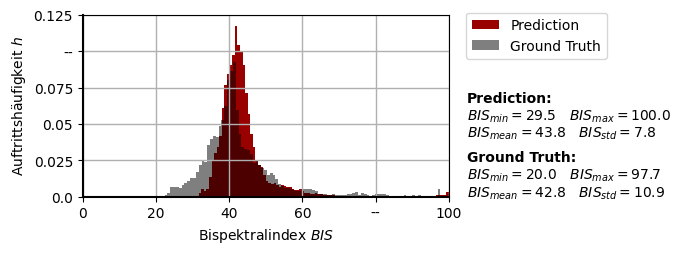

In [9]:
from utils.plotting import full_histogramm_plot

plot = full_histogramm_plot(groundtruth = bis.test_dataset[m_index_test], prediction = y_pred_male, filename='download/histogramm.pdf')
plot.show()

Finished


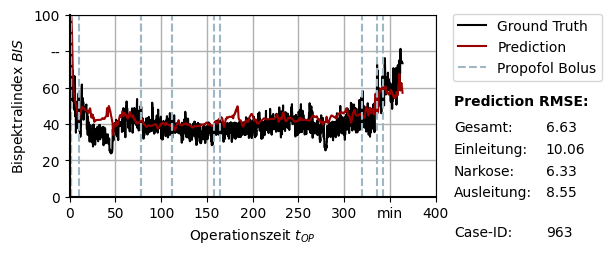

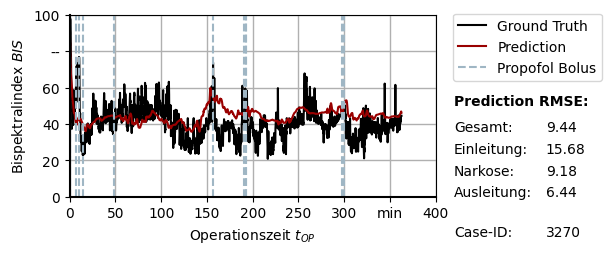

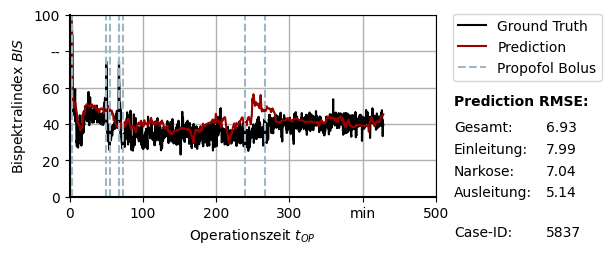

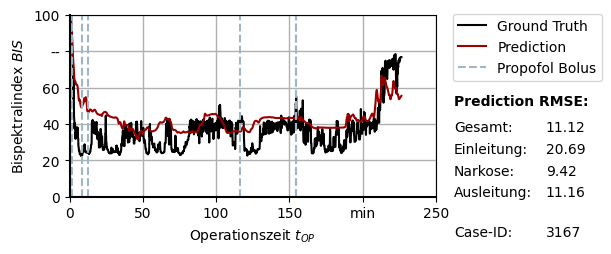

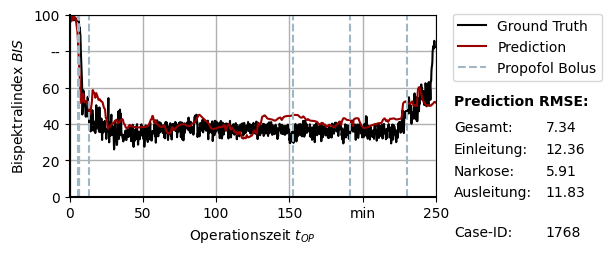

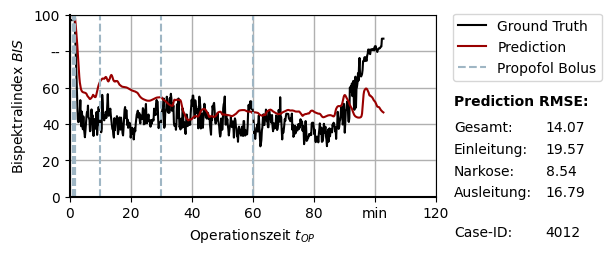

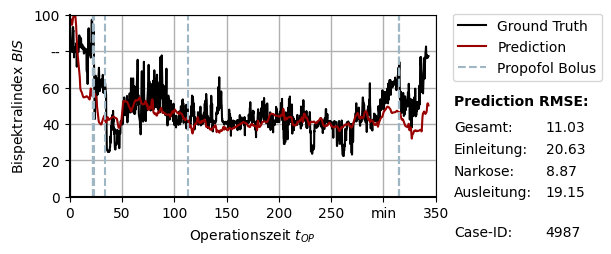

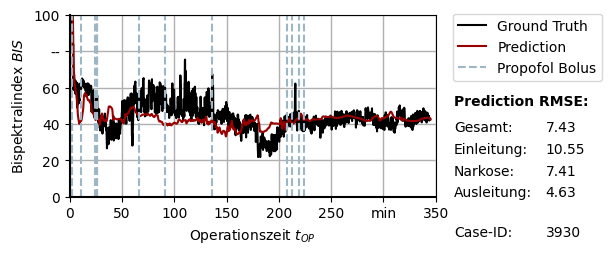

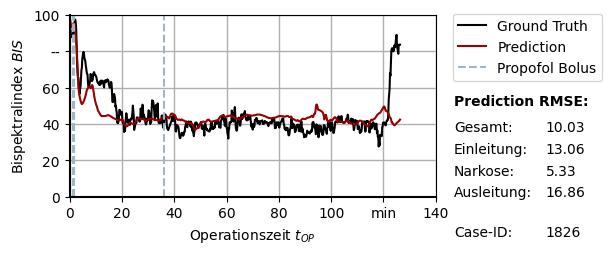

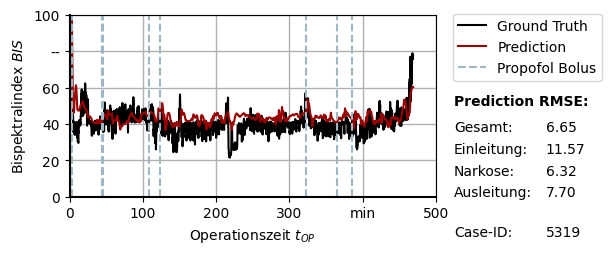

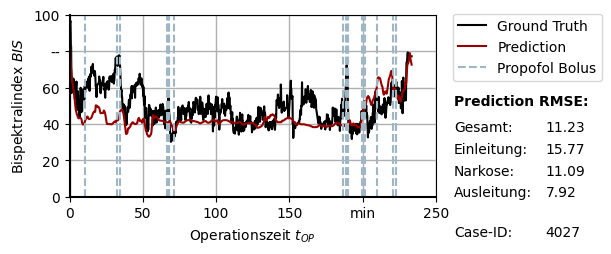

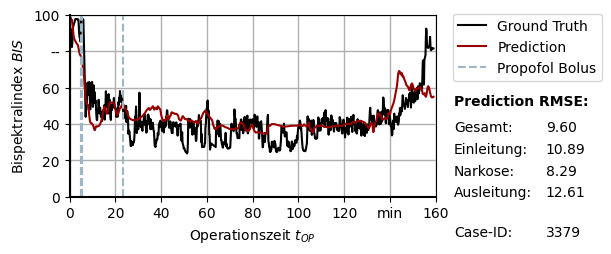

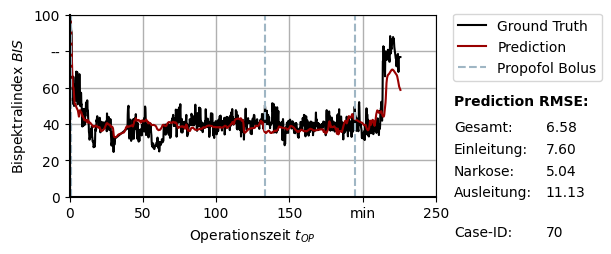

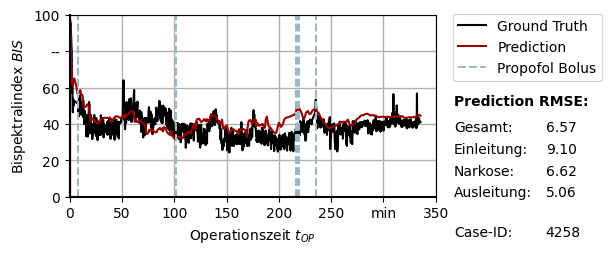

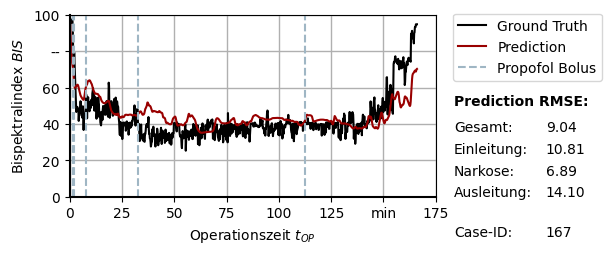

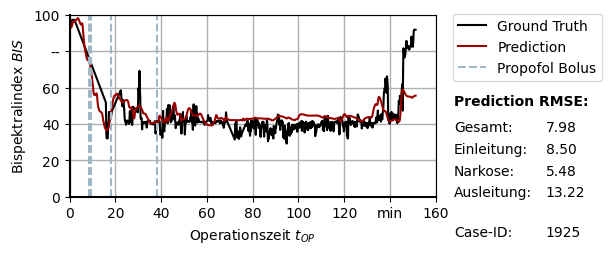

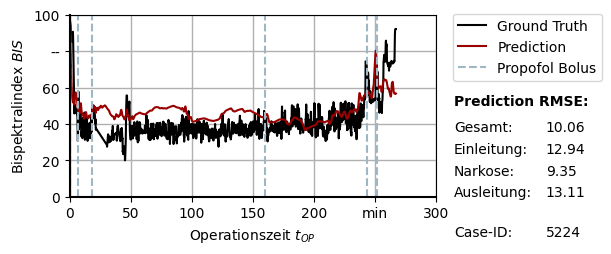

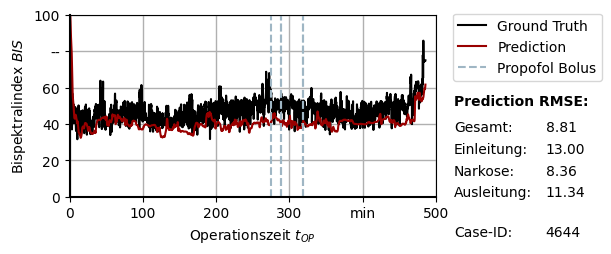

In [10]:
from utils.plotting import single_prediction_plot

for case in test_index[m_index_test]:
    single_prediction_plot(
        case = case,
        index = test_index[m_index_test],
        groundtruth = bis.test_dataset[m_index_test],
        prediction = y_pred_male,
        infusion = propofolrate.test_dataset[m_index_test],
        error = 'Prediction RMSE',
        filename = 'download/' + str(case) + '_male.pdf')

print('Finished')

# Testing Female

In [ ]:
### Predict on the test set
from utils.evaluation import phases_report, phases_report_std

print('Testmetriken:')

report = phases_report(y_pred_female, bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])
report

In [12]:
phases_report_std(report, y_pred_female, bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])

All      	min: 	 3 	max: 	 2
Induction 	min: 	 4 	max: 	 1
Maintenance 	min: 	 5 	max: 	 2
Recovery 	min: 	 3 	max: 	 5


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,48.02,91.01,2.13,3.19,2.38,3.50
Induction,136.85,397.72,4.27,8.44,4.31,6.71
Maintenance,35.84,53.11,1.95,2.77,2.01,2.82
Recovery,71.44,186.30,3.58,6.45,3.12,6.04


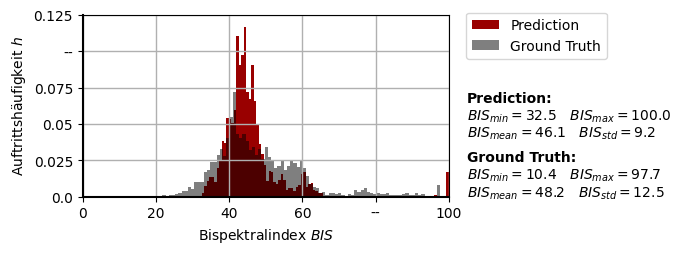

In [13]:
from utils.plotting import full_histogramm_plot

plot = full_histogramm_plot(groundtruth = bis.test_dataset[f_index_test], prediction = y_pred_female, filename='download/histogramm_female.pdf')
plot.show()

Finished


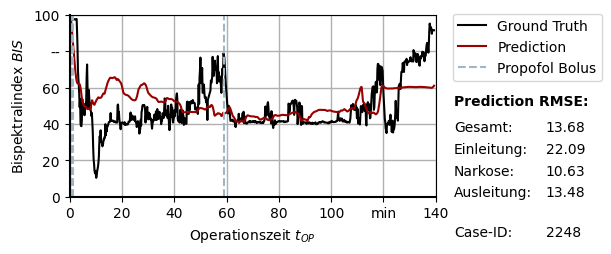

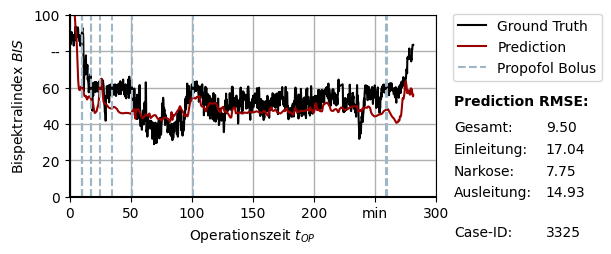

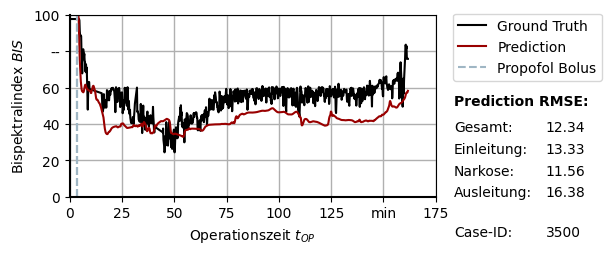

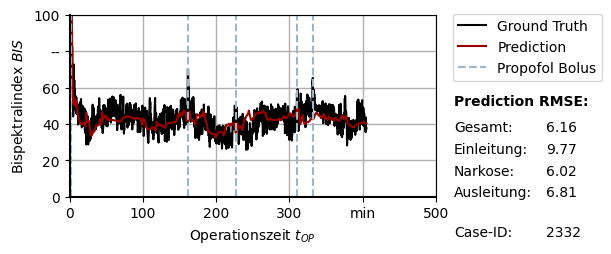

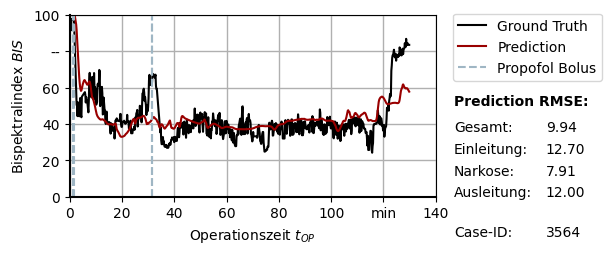

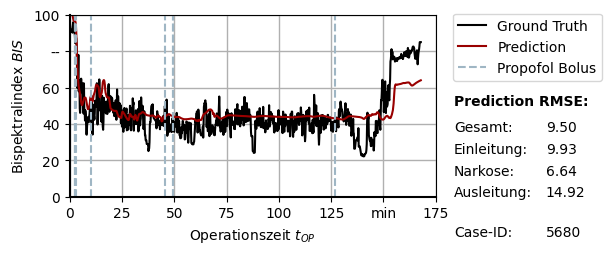

In [14]:
from utils.plotting import single_prediction_plot

for case in test_index[f_index_test]:
    single_prediction_plot(
        case = case,
        index = test_index[f_index_test],
        groundtruth = bis.test_dataset[f_index_test],
        prediction = y_pred_female,
        infusion = propofolrate.test_dataset[f_index_test],
        error = 'Prediction RMSE',
        filename = 'download/' + str(case) + '_female.pdf')

print('Finished')